In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def logic_win(x,x_r):
    return (x >= x_r[0]) & (x < x_r[1])

In [2]:
path = '../Data/UK/combined_collisions.csv'

df = pd.read_csv(path)
df.drop(columns='Unnamed: 0',inplace=True)

#### Clean up dataset

In [28]:
#Time column has some nans in it, must drop those entries

def is_str(x):
    Nx = len(x)
    I = np.ones(Nx).astype(bool)
    for ii in range(Nx):
        if type(x[ii]) != str:
            I[ii] = False
    return I

df = df.loc[is_str(df.Time.values),:]
df.aadf_Count_point_id = df.aadf_Count_point_id.values.astype(int)

In [29]:
#make hour, year and month columns
    #hour will be rounded 
def get_hour(T):
    Nt = len(T)
    H = np.zeros(Nt).astype(int)
    for ii in range(Nt):
        s = T[ii].split(':')
        h = int(s[0])
        m = int(s[1])
        if m > 30:
            h += 1
        H[ii] = h % 24
    return H

def get_ymd(D):
    Nd = len(D)
    # |
    ymd = np.zeros((Nd,3)).astype(int)
    for ii in range(Nd):
        s = D[ii].split('-')
        for nn in range(3):
            ymd[ii,nn] = int(s[nn])
    return ymd

df[['y','m','d']] = get_ymd(df.Date.values)
df['h'] = get_hour(df.Time.values)

In [30]:
#filter data out for a partciular geographic location. Here we choose Greater London

#central London box
Lat_r = [51.475,51.543]
Lon_r = [-0.179,0.023]

I_lat = (df.Latitude > Lat_r[0]) & (df.Latitude < Lat_r[1])
I_lon = (df.Longitude > Lon_r[0]) & (df.Longitude < Lon_r[1])
I = I_lat & I_lon

df_lond = df.loc[I,:].copy()

In [31]:
#drop all data that don't have traffic matches

I = df_lond.match == True
df_lond = df_lond.loc[I,:]

#### Make neighborhoods features

In [32]:
#Make a 3 (Lat, N/S) x 6 (Lon, E/W) grid
Nlat = 3
Nlon = 6
Nneigh = Nlon*Nlat

edges_lat = np.linspace(*Lat_r,Nlat+1)
dlat = np.diff(edges_lat)[0]
bins_lat = edges_lat[:-1]+0.5*dlat
edges_lon = np.linspace(*Lon_r,Nlon+1)
dlon = np.diff(edges_lon)[0]
bins_lon = edges_lon[:-1]+0.5*dlon

coord_neigh = [None]*Nneigh

df_lond['neigh'] = 0 #initialize neighborhood feature
ir = 0 #these are lat bins (rows)
ic = 0 #lon bins
for ii in range(Nneigh):
    Ilat = logic_win(df_lond.Latitude,(edges_lat[ir],edges_lat[ir+1]))
    Ilon = logic_win(df_lond.Longitude,(edges_lon[ic],edges_lon[ic+1]))
    I = Ilat & Ilon
    df_lond.loc[I,'neigh'] = ii
    
    coord_neigh[ii] = np.array([bins_lat[ir],bins_lon[ic]])
    
    ic+=1
    if ic == Nlon:
        ic = 0
        ir+=1

#### Look at traffic volume in neighborhoods

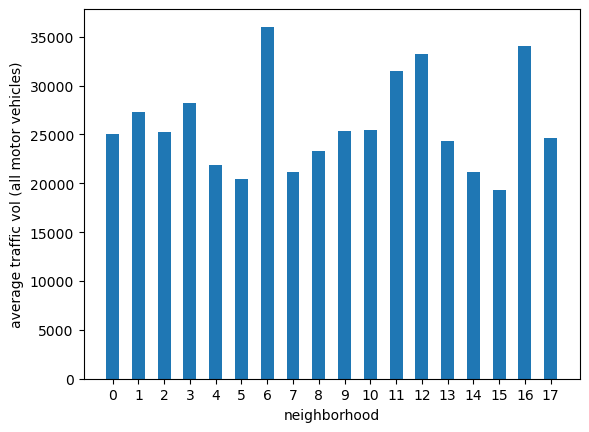

In [33]:
#get average traffic volume across all incidents for neighborhoods

feat = 'aadf_All_motor_vehicles'
#feat = 'aadf_Pedal_cycles'

TVol_neigh = np.zeros(Nneigh)
for ii in range(Nneigh):
    I = df_lond.neigh == ii
    TVol_neigh[ii] = df_lond.loc[I,feat].values.mean()
    
plt.bar(np.arange(Nneigh).astype(int),TVol_neigh,width=0.5)
plt.xlabel('neighborhood')
plt.ylabel('average traffic vol (all motor vehicles)')
plt.xticks(np.arange(Nneigh).astype(int))
plt.show()

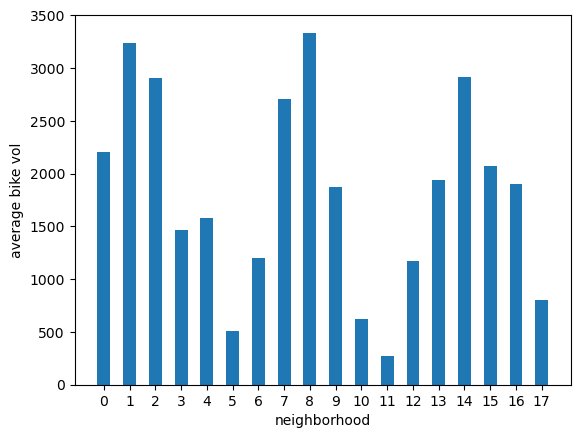

In [34]:
#get average bike volume across all incidents for neighborhoods

#feat = 'aadf_All_motor_vehicles'
feat = 'aadf_Pedal_cycles'

TVol_neigh = np.zeros(Nneigh)
for ii in range(Nneigh):
    I = df_lond.neigh == ii
    TVol_neigh[ii] = df_lond.loc[I,feat].values.mean()
    
plt.bar(np.arange(Nneigh).astype(int),TVol_neigh,width=0.5)
plt.xlabel('neighborhood')
plt.ylabel('average bike vol')
plt.xticks(np.arange(Nneigh).astype(int))
plt.show()

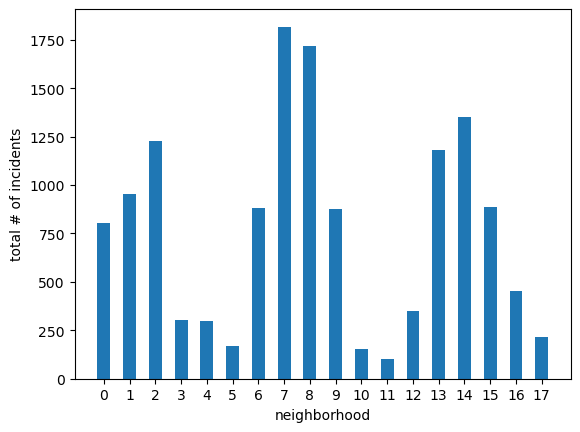

In [35]:
#get total # of incidents in neighborhoods 

#feat = 'aadf_All_motor_vehicles'
feat = 'aadf_Pedal_cycles'

TInc_neigh = np.zeros(Nneigh)
for ii in range(Nneigh):
    I = df_lond.neigh.values == ii
    TInc_neigh[ii] = I.sum()
    
plt.bar(np.arange(Nneigh).astype(int),TInc_neigh,width=0.5)
plt.xlabel('neighborhood')
plt.ylabel('total # of incidents')
plt.xticks(np.arange(Nneigh).astype(int))
plt.show()

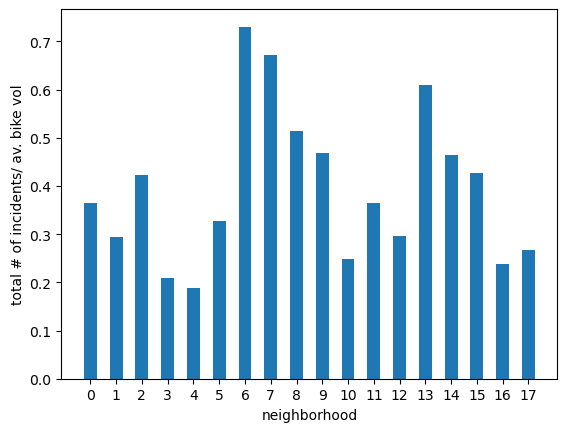

In [36]:
#plot total number of indicents normalized by bike volume

TInc_neigh_bikevol = TInc_neigh/TVol_neigh

plt.bar(np.arange(Nneigh).astype(int),TInc_neigh_bikevol,width=0.5)
plt.xlabel('neighborhood')
plt.ylabel('total # of incidents/ av. bike vol')
plt.xticks(np.arange(Nneigh).astype(int))
plt.show()

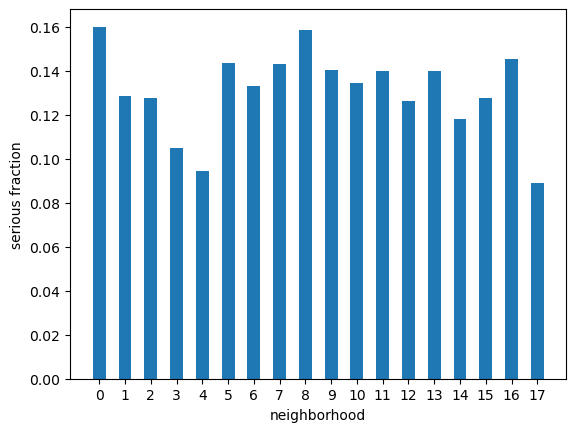

In [37]:
#plot frac. of serious accidents in each neighborhood

Tserious_neigh = np.zeros(Nneigh)
for ii in range(Nneigh):
    I = df_lond.neigh == ii
    Tserious_neigh[ii] = np.logical_not(df_lond.loc[I,'slight'].values).sum()
    
plt.bar(np.arange(Nneigh).astype(int),Tserious_neigh/TInc_neigh,width=0.5)
plt.xlabel('neighborhood')
plt.ylabel('serious fraction')
plt.xticks(np.arange(Nneigh).astype(int))
plt.show()

In [ ]:
#idea, could maybe regress on the number of accidents particular roads have. Could form a list of 
#roads or sections within the dataset, maybe selecting those with enough data.
#Could even do this with neighborhoods, regress on total # of incidents that the neighborhood will have
#based on some features (like traffic volume) 

In [18]:
df_lond.columns

Index(['Accident_Index', 'Location_Easting_OSGR', 'Location_Northing_OSGR',
       'Longitude', 'Latitude', 'Police_Force', 'Accident_Severity',
       'Number_of_Vehicles', 'Number_of_Casualties', 'Date', 'Day_of_Week',
       'Time', 'Local_Authority_(District)', 'Local_Authority_(Highway)',
       '1st_Road_Class', '1st_Road_Number', 'Road_Type', 'Speed_limit',
       'Junction_Detail', 'Junction_Control', '2nd_Road_Class',
       '2nd_Road_Number', 'Pedestrian_Crossing-Human_Control',
       'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions',
       'Weather_Conditions', 'Road_Surface_Conditions',
       'Special_Conditions_at_Site', 'Carriageway_Hazards',
       'Urban_or_Rural_Area', 'Did_Police_Officer_Attend_Scene_of_Accident',
       'LSOA_of_Accident_Location', 'Vehicle_Type', 'Bicycles', 'fatal',
       'serious', 'slight', 'geometry', 'index_right', 'Road_name',
       'Road_name2', 'in_london', 'aadf_Count_point_id', 'aadf_Year',
       'aadf_Region_id', 'aadf_R

#### Make a DataFrame using df_lond that has entries only for traffic IDs. Main feature is # of incidents. 
- Other features are the aadf features that go along with the ID
- Also maybe some averaged features from accidents dataset (like junction control, maybe just use the classification with the most entries for that ID)
- Maybe the target variable should be number of incidents normalized by the bike volume (this is prob. of an incident)

In [38]:
traf_IDs = np.array(df_lond.aadf_Count_point_id.value_counts().index)
Ninc_IDs = np.array(df_lond.aadf_Count_point_id.value_counts().values)

I = Ninc_IDs > 20
I.sum()

#so there are > 200 sites with more than 20 incidents. Maybe a regression can be done on these sites to determine total # of accidents

223

##### Features to include
- all aadf features (do they neeed to be averaged over year? Maybe just average anyway)
- modes of classification features in accidents
- num. of incidents
- num. of serious and fatal incidents
- num. of indcidents normalized to bike volume from aadf

In [40]:
IDs_df = traf_IDs[I]
Nid = len(IDs_df)

#features to include
    -

223

In [49]:
from scipy import stats as st
m,c = st.mode(np.array([1,0,1,1,1]),keepdims=False)

4

In [56]:
df_lond.Did_Police_Officer_Attend_Scene_of_Accident.value_counts()

1    9681
2    3930
3     124
Name: Did_Police_Officer_Attend_Scene_of_Accident, dtype: int64